In [178]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# Acquire

In [3]:
invoices = pd.read_csv('saas.csv')

In [4]:
invoices.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


# Prepare

In [6]:
invoices.columns = [col.lower() for col in invoices]

In [8]:
invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   month_invoiced     790458 non-null  object 
 1   customer_id        790458 non-null  int64  
 2   invoice_id         790458 non-null  int64  
 3   subscription_type  790458 non-null  float64
 4   amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [9]:
invoices.month_invoiced = pd.to_datetime(invoices.month_invoiced)

In [11]:
invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   month_invoiced     790458 non-null  datetime64[ns]
 1   customer_id        790458 non-null  int64         
 2   invoice_id         790458 non-null  int64         
 3   subscription_type  790458 non-null  float64       
 4   amount             790458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 30.2 MB


In [14]:
invoices = invoices.set_index('month_invoiced')

In [15]:
invoices.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


# Explore

In [24]:
invoices.index.min(), invoices.index.max()

(Timestamp('2014-01-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [25]:
invoices.isna().sum()

customer_id          0
invoice_id           0
subscription_type    0
amount               0
dtype: int64

In [26]:
invoices.subscription_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

In [27]:
invoices.amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [31]:
invoices.customer_id.value_counts()

1014700    48
1008258    48
1008248    48
1008249    48
1008251    48
           ..
1004048     1
1025794     1
1023982     1
1010805     1
1029399     1
Name: customer_id, Length: 29400, dtype: int64

<AxesSubplot:xlabel='month_invoiced'>

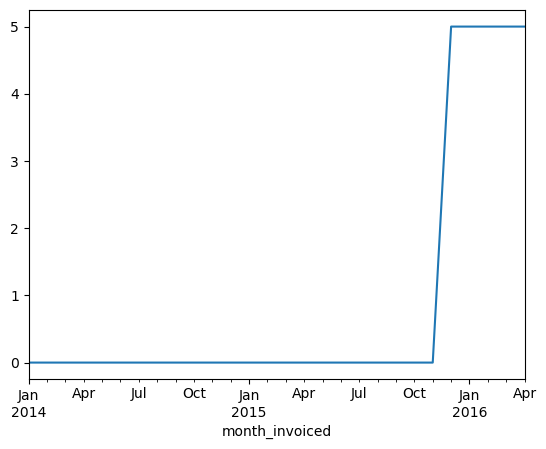

In [36]:
invoices[invoices.customer_id == 1000000].amount.plot()

In [40]:
monthly_totals = invoices.resample('M')['subscription_type','amount'].sum()

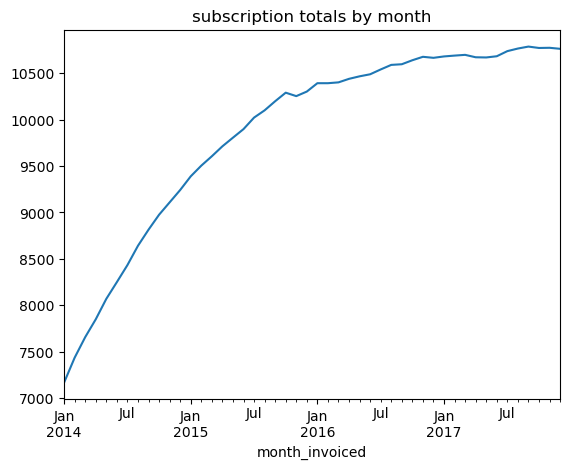

In [46]:
monthly_totals.subscription_type.plot(title='subscription totals by month');

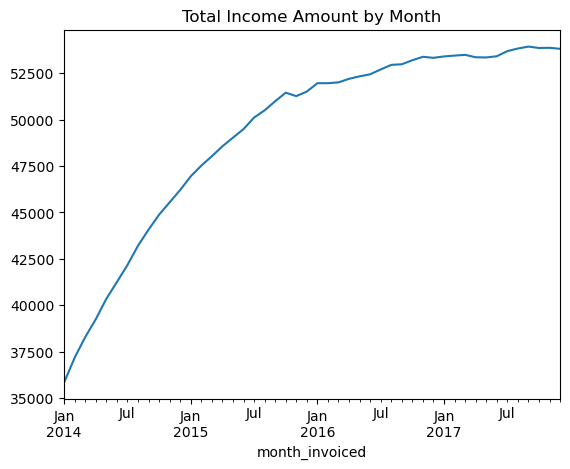

In [51]:
monthly_totals.amount.plot(title='Total Income Amount by Month');

In [61]:
monthly_avg = invoices.resample('M')['subscription_type','amount'].mean()

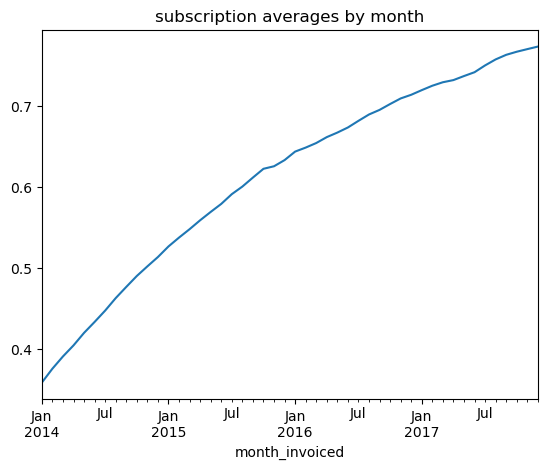

In [50]:
monthly_avg.subscription_type.plot(title='subscription averages by month');

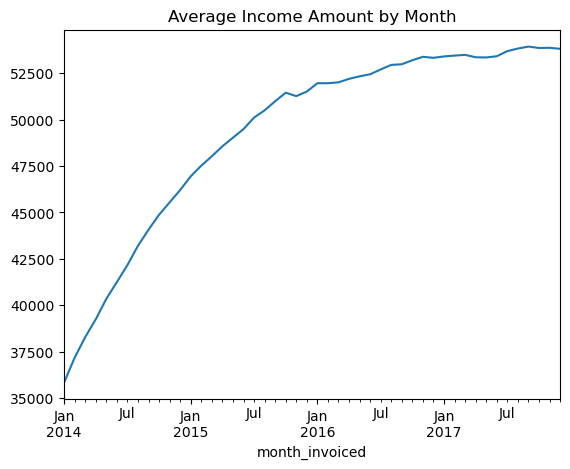

In [52]:
monthly_totals.amount.plot(title='Average Income Amount by Month');

In [60]:
yearly_avg = invoices.resample('Y')['subscription_type','amount'].mean()

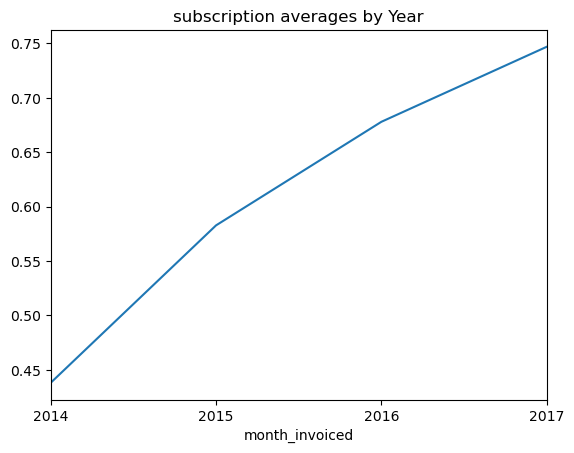

In [62]:
yearly_avg.subscription_type.plot(title='subscription averages by Year');

## 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [67]:
invoices.shape

(790458, 4)

In [101]:
resampled = invoices.resample('M').mean()

In [102]:
train_split_index = round(len(resampled) * .5)
val_split_index = round(len(resampled) * .8)
train = resampled[:train_split_index].drop(
    columns=['customer_id', 'invoice_id'])
validate =resampled[train_split_index:val_split_index].drop(
    columns=['customer_id', 'invoice_id'])
test = resampled[val_split_index:].drop(
    columns=['customer_id', 'invoice_id'])

In [95]:
train

,subscription_type,amount
month_invoiced,,
2014-01-31,0.358500,1.792500
2014-02-28,0.375657,1.878283
2014-03-31,0.390785,1.953926
2014-04-30,0.404420,2.022099
2014-05-31,0.419905,2.099527
2014-06-30,0.433396,2.166982
2014-07-31,0.447403,2.237017
2014-08-31,0.462832,2.314160
2014-09-30,0.476641,2.383205


In [103]:
len(train), len(validate), len(test), len(invoices.resample('M').mean())

(24, 14, 10, 48)

In [104]:
len(resampled) == len(train) + len(validate) + len(test)

True

In [123]:
pd.concat([train.tail(1), validate.head(1), validate.tail(1), test.head(1)])

,subscription_type,amount
month_invoiced,,
2015-12-31,0.633206,3.166031
2016-01-31,0.643724,3.218622
2017-02-28,0.725053,3.625263
2017-03-31,0.729356,3.646778


In [71]:
y = train.amount.resample('M').mean()
results_amount = sm.tsa.seasonal_decompose(y)

In [73]:
decomposition = pd.DataFrame({
    'y': results_amount.observed,
    'trend': results_amount.trend,
    'seasonal': results_amount.seasonal,
    'residual': results_amount.resid})

In [74]:
decomposition

,y,trend,seasonal,residual
month_invoiced,,,,
2014-01-31,1.792500,NaN,0.008070,NaN
2014-02-28,1.878283,NaN,-0.000238,NaN
2014-03-31,1.953926,NaN,-0.006652,NaN
2014-04-30,2.022099,NaN,-0.005745,NaN
2014-05-31,2.099527,NaN,-0.009707,NaN
2014-06-30,2.166982,NaN,-0.011643,NaN
2014-07-31,2.237017,2.233046,-0.004062,0.008033
2014-08-31,2.314160,2.301799,0.003472,0.008889
2014-09-30,2.383205,2.368264,0.009951,0.004990


<AxesSubplot:xlabel='month_invoiced'>

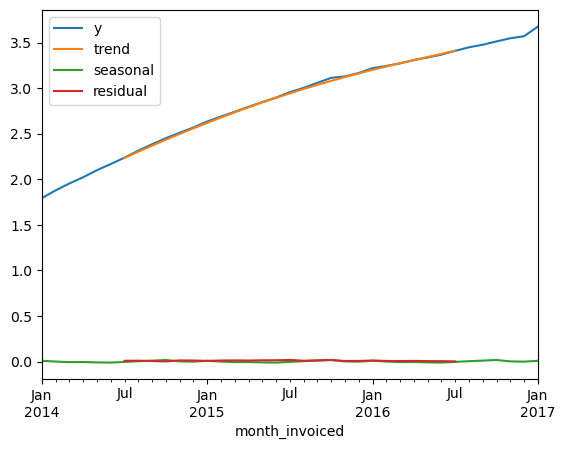

In [75]:
decomposition.plot()

# 2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
- Last Observed Value
- Simple Average
- Moving Average
- Holt's Linear Trend
- Holt's Seasonal Trend
- Based on previous year/month/etc., this is up to you.

In [132]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(mean_squared_error(validate[target_var], 
                                    yhat_df[target_var], 
                                    squared=False), 4)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()
    
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [159]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [160]:
train.head()

,subscription_type,amount
month_invoiced,,
2014-01-31,0.358500,1.792500
2014-02-28,0.375657,1.878283
2014-03-31,0.390785,1.953926
2014-04-30,0.404420,2.022099
2014-05-31,0.419905,2.099527


### Last Observed Value

In [161]:
train['subscription_type'][-1:][0]

0.6332062945660192

In [162]:
# Last observed value for subscriptions
last_subs = train['subscription_type'][-1:][0]
last_subs

0.6332062945660192

In [163]:
# take the last amount
last_amount = train['amount'][-1:][0]
last_amount

3.166031472830096

In [164]:
yhat_df = pd.DataFrame(
    {'subscription_type': [last_subs],
     'amount': [last_amount]},
    index=validate.index)

yhat_df.head()

,subscription_type,amount
month_invoiced,,
2016-01-31,0.633206,3.166031
2016-02-29,0.633206,3.166031
2016-03-31,0.633206,3.166031
2016-04-30,0.633206,3.166031
2016-05-31,0.633206,3.166031


In [165]:
round(mean_squared_error(validate['amount'], 
                                    yhat_df['amount'], 
                                    squared=False), 4)

0.2889

subscription_type -- RMSE: 0.0578


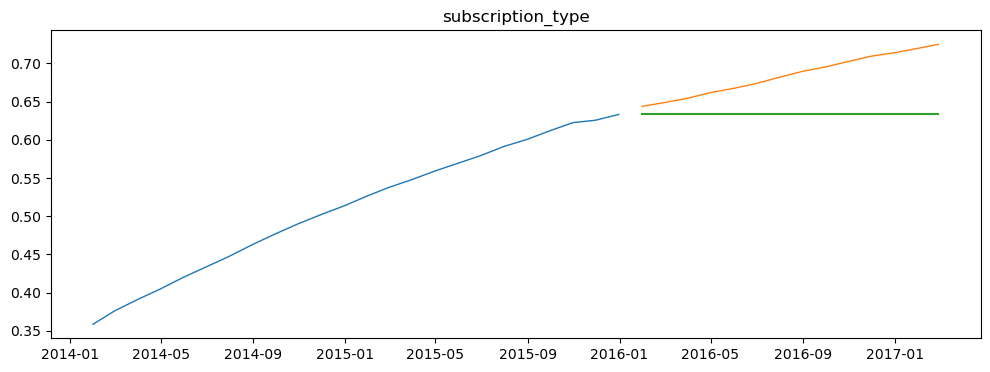

amount -- RMSE: 0.2889


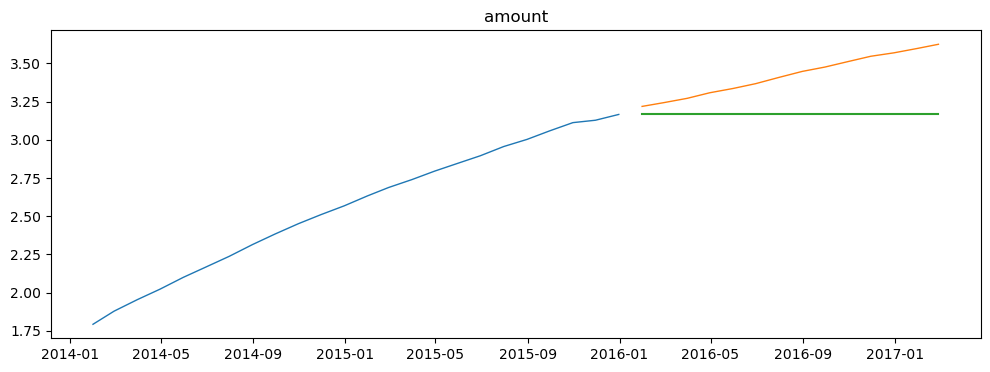

In [166]:
for col in train.columns:
    plot_and_eval(col)

In [167]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,last_observed_value,subscription_type,0.0578
1,last_observed_value,amount,0.2889


### Simple Average

In [168]:
# compute simple average
avg_subs = round(train['subscription_type'].mean(), 4)
avg_subs

0.5116

In [169]:
avg_amount = round(train['amount'].mean(), 4)
avg_amount

2.5582

In [170]:
def make_predictions(subs=None, amount=None):
    yhat_df = pd.DataFrame({'subscription_type': [subs],
                           'amount': [amount]},
                          index=validate.index)
    return yhat_df

In [171]:
yhat_df = make_predictions(avg_subs, avg_amount)

subscription_type -- RMSE: 0.1751


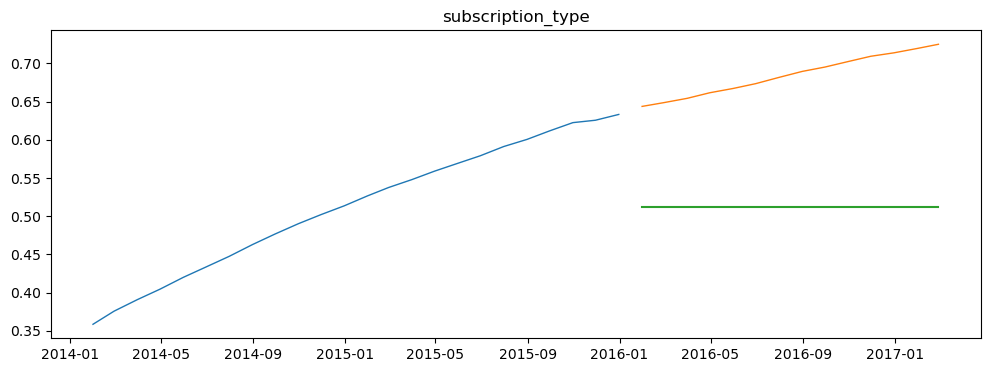

amount -- RMSE: 0.8752


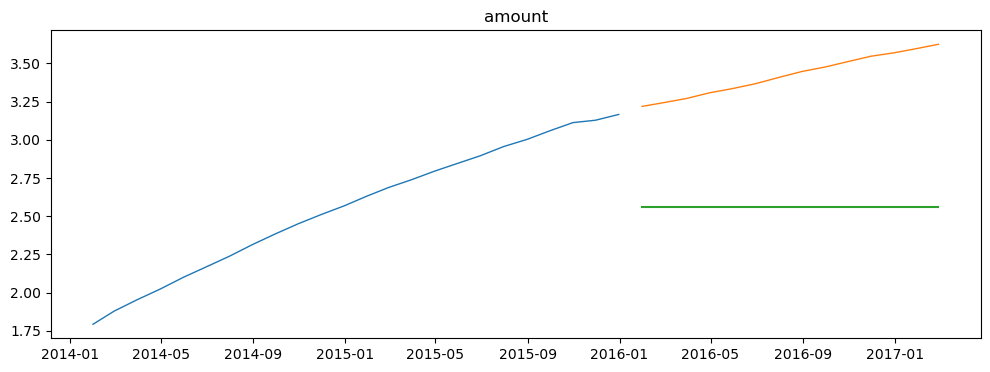

In [172]:
for col in train.columns:
    plot_and_eval(col)

In [173]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,last_observed_value,subscription_type,0.0578
1,last_observed_value,amount,0.2889
2,simple_average,subscription_type,0.1751
3,simple_average,amount,0.8752


### Rolling Average

In [174]:
train['subscription_type'].rolling(30)

Rolling [window=30,center=False,axis=0,method=single]

In [175]:
round(train['subscription_type'].rolling(1).mean(), 4)

month_invoiced
2014-01-31    0.3585
2014-02-28    0.3757
2014-03-31    0.3908
2014-04-30    0.4044
2014-05-31    0.4199
2014-06-30    0.4334
2014-07-31    0.4474
2014-08-31    0.4628
2014-09-30    0.4766
2014-10-31    0.4901
2014-11-30    0.5020
2014-12-31    0.5136
2015-01-31    0.5266
2015-02-28    0.5376
2015-03-31    0.5479
2015-04-30    0.5589
2015-05-31    0.5692
2015-06-30    0.5791
2015-07-31    0.5912
2015-08-31    0.6005
2015-09-30    0.6117
2015-10-31    0.6225
2015-11-30    0.6256
2015-12-31    0.6332
Freq: M, Name: subscription_type, dtype: float64

In [176]:
periods = [1, 3, 6, 12, 24] 

# take 30 day rolling average, since our data is sliced by months, this is one period
# then take the last element and that will the one that propogates 
# forward as our prediction. 

for p in periods: 
    rolling_subs = round(train['subscription_type'].rolling(p).mean()[-1], 4)
    rolling_amount = round(train['amount'].rolling(p).mean()[-1], 4)
    yhat_df = make_predictions(rolling_subs, rolling_amount)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

In [177]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,subscription_type,0.0578
1,last_observed_value,amount,0.2889
2,simple_average,subscription_type,0.1751
3,simple_average,amount,0.8752
4,1_month_moving_avg,subscription_type,0.0578
5,1_month_moving_avg,amount,0.2890
6,3_month_moving_avg,subscription_type,0.0633
7,3_month_moving_avg,amount,0.3164
8,6_month_moving_avg,subscription_type,0.0753
9,6_month_moving_avg,amount,0.3765


### Holt's linear model

In [179]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/1794298677.py:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = Holt(train[col], exponential=False, damped=True)
/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/1794298677.py:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = Holt(train[col], exponential=False, damped=True)


In [180]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1228/3504309788.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


In [181]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,subscription_type,0.0578
1,last_observed_value,amount,0.2889
2,simple_average,subscription_type,0.1751
3,simple_average,amount,0.8752
4,1_month_moving_avg,subscription_type,0.0578
5,1_month_moving_avg,amount,0.2890
6,3_month_moving_avg,subscription_type,0.0633
7,3_month_moving_avg,amount,0.3164
8,6_month_moving_avg,subscription_type,0.0753
9,6_month_moving_avg,amount,0.3765
